# VAE-Gogh
The goal of this project is to generate images inspired by Van Gogh paintings. We attempt to solve this problem by implementing a [Variational Autoencoder](https://arxiv.org/abs/1312.6114)(VAE) trained on images of Van Gogh's works.

The training data was downloaded from [here](https://archive.org/download/Van.gogh.paintings). In order to train the VAE, it is convenient for the images to all be of the same size. Moreover, since this is trained (for now) without a GPU, training time for large images may be prohibitively long. Thus, all images were scaled to 64x64 with ImageMagick via the following command:

```Bash
for i in **/*.jpg; do
    convert $i -resize 64x64! $i;
done
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import math

/usr/lib64/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading the Data
We now load up all of the image files into memory. At 64x64, the whole dataset should be on the order of ~70M, which isn't so bad.

When the paintings were downloaded, they came with a sort of 'index' that points to each image path, so that file is followed to load up all of the data. Note that the original index file was named something like `Van.gogh.paintings.meta.txt` and the contents itself were slightly messy (some lines had a path repeated for some reason). The file was since renamed to `index.txt`, and the duplicate issue was fixed with a simple regex substitution in Vim, with `:%s/\(.*\),\d\+,.*/\1/g/`

In [2]:
with open("data/index.txt", "r") as index:
    lines = index.readlines()

imgs = [plt.imread("data/" + imgpath.strip(), format="jpeg") / 255.0 for imgpath in lines]   

We now preview some of the images, just for fun. For reference, the bottom-right image is the classic "Starry Night".

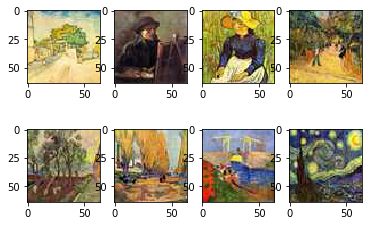

In [3]:
for i in range(8):
    img = imgs[i + 4]
    imgs.append(img)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
plt.show()

Some of the images in the dataset are grayscale. To conform to the structure of the VAE, we must convert those to an RGB encoding.

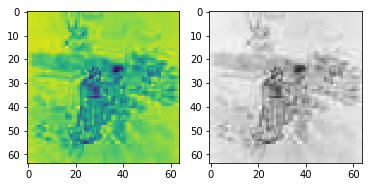

In [4]:
for i in range(len(imgs)):
    img = imgs[i]
    if len(img.shape) != 3:
        if len(img.shape) != 2:
            print("ERROR: Weird, unexpected image shape")
            raise Exception
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        imgs[i] = np.stack((img,) * 3, axis=-1)
        plt.subplot(1, 2, 2)
        plt.imshow(imgs[i])
        plt.show()

## Defining the Computation Graph
We now begin implementing the VAE itself. Variational Autoencoders consist of an encoder network that encodes an image into a much smaller latent space, represented by mean and variance vectors, followed by a decoder network that constructs new image samples from latent space codes.

For this project, convolutional neural networks will be used for both the encoder and the decoder to capture visual patterns and nuances in the training set.

### Setup
We begin by setting a few constants and organizing stuff before laying out the networks themselves.

In [40]:
tf.reset_default_graph()

BATCH_SIZE = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 64, 64, 3], name='X')
Y_out = tf.placeholder(dtype=tf.float32, shape=[None, 64, 64, 3], name='Y')
Y_flat = tf.reshape(Y_out, shape=[-1, 64 * 64 * 3])
keep_ratio = tf.placeholder(dtype=tf.float32, shape=(), name='keep_ratio')
w_kl = tf.placeholder(dtype=tf.float32, shape=(), name='w_kl')

z_dim = 8
decoder_flat_size = 3 * (64 / (2*2))**2

### The Encoder
Now we design the encoder network. The encoder will be a deep convolutional neural network that ends with dense layers that produce the mean and variance vectors for the latent space representation of individual images.

In [41]:
def encoder(X_in, keep_ratio):
    with tf.variable_scope("encoder", reuse=None):
        x = tf.reshape(X_in, shape=[-1,64,64,3])
        x = tf.layers.conv2d(x, filters=32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_ratio)
        x = tf.layers.conv2d(x, filters=32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_ratio)
        x = tf.layers.conv2d(x, filters=32, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_ratio)
        x = tf.contrib.layers.flatten(x)
        mu = tf.layers.dense(x, units=z_dim)
        s2 = tf.layers.dense(x, units=z_dim)
        e = tf.random_normal(tf.stack([tf.shape(x)[0], z_dim]))
        z = mu + tf.multiply(tf.exp(s2), e)
    return z, mu, s2

### The Decoder
Now we design the decoder network. The decoder network will consist mainly of transpose convolutional layers. It begins by using dense layers to project the latent space input to a larger dimension, then proceeds with the transpose convolutions. Finally, we flatten the signal and apply a sigmoid activation to bring values in the range $[0,1]$, and reshape finally to the desired image size.

In [42]:
def decoder(z, keep_ratio):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(z, units=decoder_flat_size/2, activation=tf.nn.relu)
        x = tf.layers.dense(x, units=decoder_flat_size, activation=tf.nn.relu)
        x = tf.reshape(x, shape=[-1, 16, 16, 3])
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_ratio)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_ratio)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=64*64*3, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1,64,64,3])
        return img

### Wiring and Computing Loss
Finally, we connect the encoder to the decoder and define the loss function and optimizers.

In [43]:
z, mu, s2 = encoder(X_in, keep_ratio)
img = decoder(z, keep_ratio)
unreshaped = tf.reshape(img, shape=[-1, 64*64*3])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0*s2 - tf.square(mu) - tf.exp(s2 * 2.0), 1)
loss = tf.reduce_mean(img_loss + w_kl * latent_loss)

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Training
With the network defined, we can train the model.

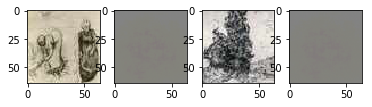

0 815.09094 815.09094 0.9243678


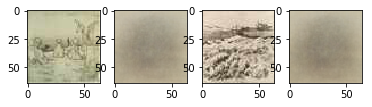

100 456.13428 445.67255 10.461739


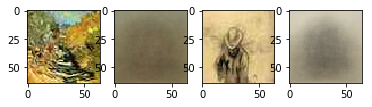

200 458.4356 444.7256 6.8549957


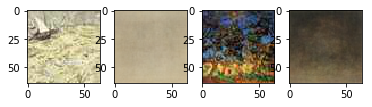

300 400.48007 384.36258 8.058741


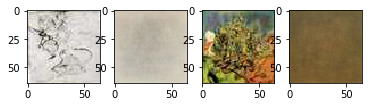

400 359.2314 336.05753 7.7246304


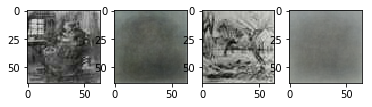

500 354.46716 329.35858 8.36954


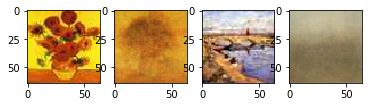

600 365.524 337.11282 7.1027894


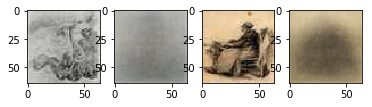

700 357.58154 325.92642 7.9137793


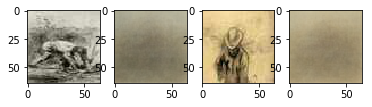

800 377.75067 338.66913 7.816303


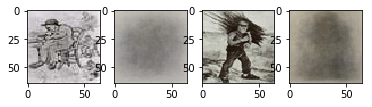

900 352.1583 306.6351 9.104641


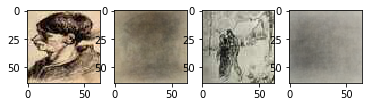

1000 378.2027 328.05298 8.358294


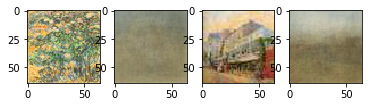

1100 356.84827 307.5492 8.216509


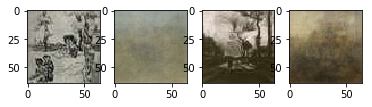

1200 336.9726 283.29102 8.946931


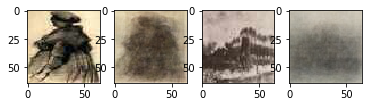

1300 360.48645 299.73798 8.678353


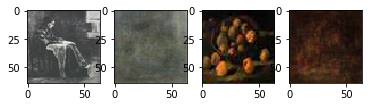

1400 348.21118 290.45358 8.251085


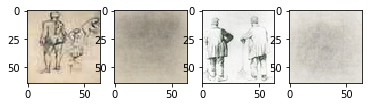

1500 360.82147 306.46948 7.7645693


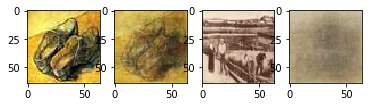

1600 309.62433 246.04358 9.082968


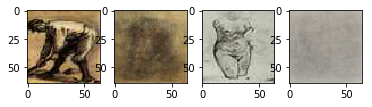

1700 315.4406 248.52776 8.364109


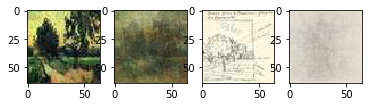

1800 348.71857 273.7374 9.372646


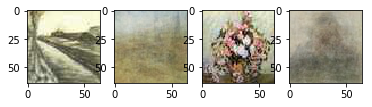

1900 340.01648 259.0227 8.99931


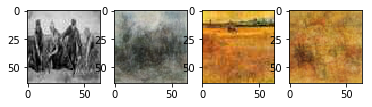

2000 313.17902 240.51541 8.073732


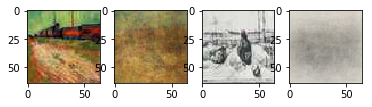

2100 322.88226 245.9892 8.543673


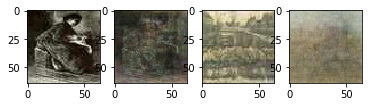

2200 331.86838 239.00404 9.286432


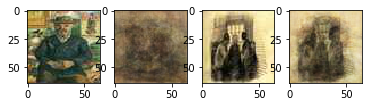

2300 324.43552 230.61714 8.528942


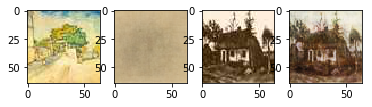

2400 348.2875 254.43262 8.532261


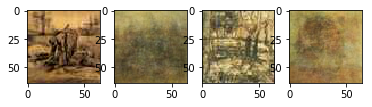

2500 346.79626 250.91635 7.989994


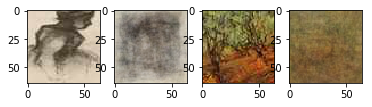

2600 336.00464 233.70297 8.525139


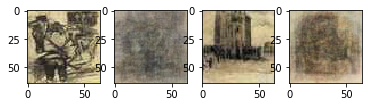

2700 359.03696 245.96596 8.697769


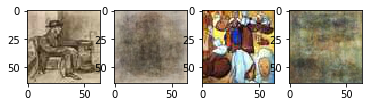

2800 376.61755 273.63507 7.3558927


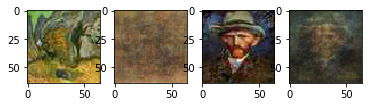

2900 319.07306 210.64255 7.745037


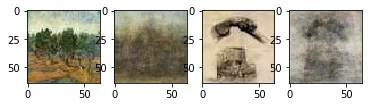

3000 393.6416 276.33453 7.820471


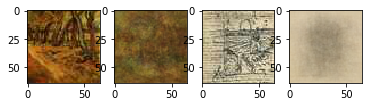

3100 355.30798 235.57233 7.4834776


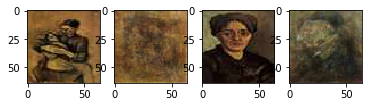

3200 362.3938 248.48973 7.119004


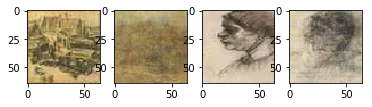

3300 330.72675 208.80817 7.619913


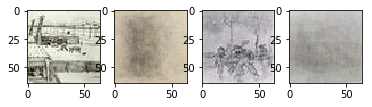

3400 350.21478 230.64398 7.0335755


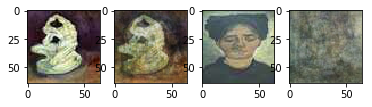

3500 361.83966 231.12805 7.688918


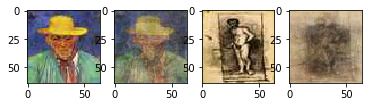

3600 351.2269 200.0575 8.398299


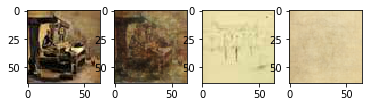

3700 359.85342 227.18936 6.982319


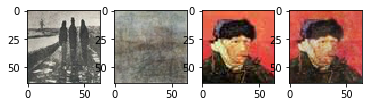

3800 373.10638 223.95265 7.8501973


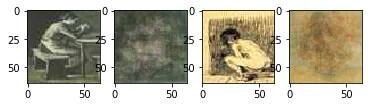

3900 419.42133 277.53757 7.0941887


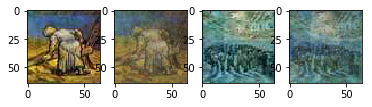

4000 340.18158 201.22089 6.948036


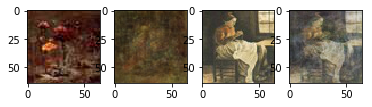

4100 367.456 237.328 6.5063987


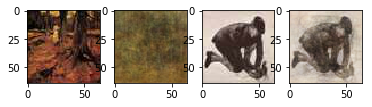

4200 382.31427 241.0411 7.0636578


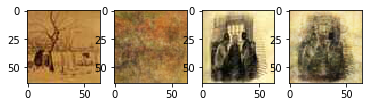

4300 377.94385 226.57571 7.208007


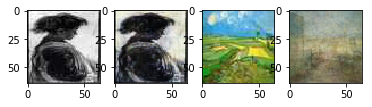

4400 375.38495 207.06941 7.6507044


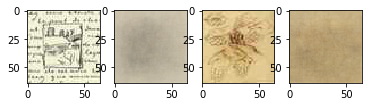

4500 390.91895 245.17685 6.3366117


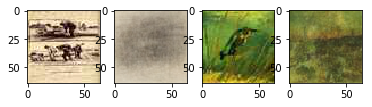

4600 381.79285 220.65413 7.006032


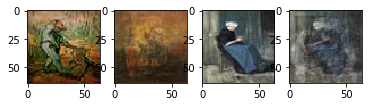

4700 401.2739 248.64981 6.359337


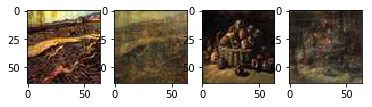

4800 434.4563 283.24786 6.3003497


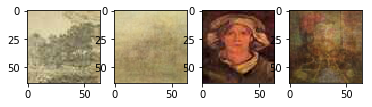

4900 422.10596 271.6093 6.270693


In [44]:
start_idx = 0
wkl = 0
prev_latent_loss = 0
for i in range(5000):
    if start_idx >= len(imgs):
        np.random.shuffle(imgs)
        start_idx = 0
    
    batch = imgs[start_idx:np.min([start_idx + BATCH_SIZE, len(imgs)])]
    
    sess.run(optimizer, feed_dict = {X_in: batch, Y_out: batch, keep_ratio: 0.8, w_kl: wkl})
    
    if not i % 100:
        ls, d, i_ls, d_ls, mn, sigm = sess.run([loss, img, img_loss, latent_loss, mu, s2], feed_dict = {X_in: batch, Y_out: batch, keep_ratio: 1.0, w_kl: wkl})
        plt.subplot(1, 4, 1)
        plt.imshow(np.reshape(batch[0], [64, 64, 3]))
        plt.subplot(1, 4, 2)
        plt.imshow(d[0])
        plt.subplot(1, 4, 3)
        plt.imshow(np.reshape(batch[1], [64, 64, 3]))
        plt.subplot(1, 4, 4)
        plt.imshow(d[1])
        plt.show()
        lat_loss = np.mean(d_ls)
        print(i, ls, np.mean(i_ls), lat_loss)
        if lat_loss - prev_latent_loss >= 0.0:
            wkl += 1.0
        prev_latent_loss = lat_loss
    start_idx += BATCH_SIZE

## Generating Data
With the trained VAE, we may now try to generate completely new paintings with the decoder. The decoder just needs to be passed data that is sampled from the standard Gaussian distribution in the latent space, and hopefully decent-looking paintings will be produced.

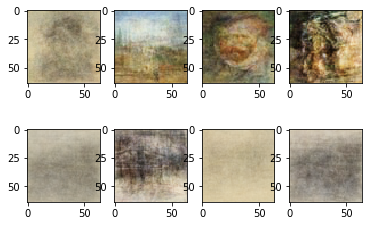

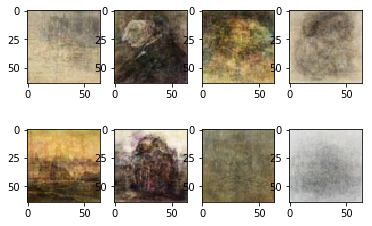

In [66]:
for j in range(2):
    for i in range(8):
        random_code = np.random.multivariate_normal(np.zeros(z_dim), np.eye(z_dim)).reshape(1,-1)
        new_img = sess.run(img, feed_dict={z: random_code, keep_ratio: 1.0})
        plt.subplot(2,4,i + 1)
        plt.imshow(new_img[0])
    plt.show()